In [13]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.io import fits

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [ ]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = False
total = True

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

print(f'pipeline_dir: {pipeline_dir}')

In [21]:
input_dir = config.machine.dir_03

In [22]:
lens_pickles = sorted(glob(config.machine.dir_02 + '/lens_with_subhalos_*.pkl'))
lens_uids = [int(os.path.basename(i).split('_')[3].split('.')[0]) for i in lens_pickles]

In [23]:
pipeline_params = util.hydra_to_dict(config.pipeline)
bands = pipeline_params['bands']
limit = pipeline_params['limit']
pieces = pipeline_params['pieces']
if limit is not None:
    lens_uids = lens_uids[:limit]

In [24]:
uid = np.random.choice(lens_uids)
lens = util.unpickle(os.path.join(input_dir, f'lens_{str(uid).zfill(8)}.pkl'))

In [25]:
arrays = [np.load(f'{input_dir}/array_{lens.uid}_{band}.npy') for band in bands]
if pieces:
    lens_surface_brightness = [np.load(f'{input_dir}/array_{lens.uid}_lens_{band}.npy') for band in bands]
    source_surface_brightness = [np.load(f'{input_dir}/array_{lens.uid}_source_{band}.npy') for band in bands]

In [35]:
color_image = np.load(os.path.join(config.machine.dir_05, f'galsim_color_{lens.uid}.npy'))

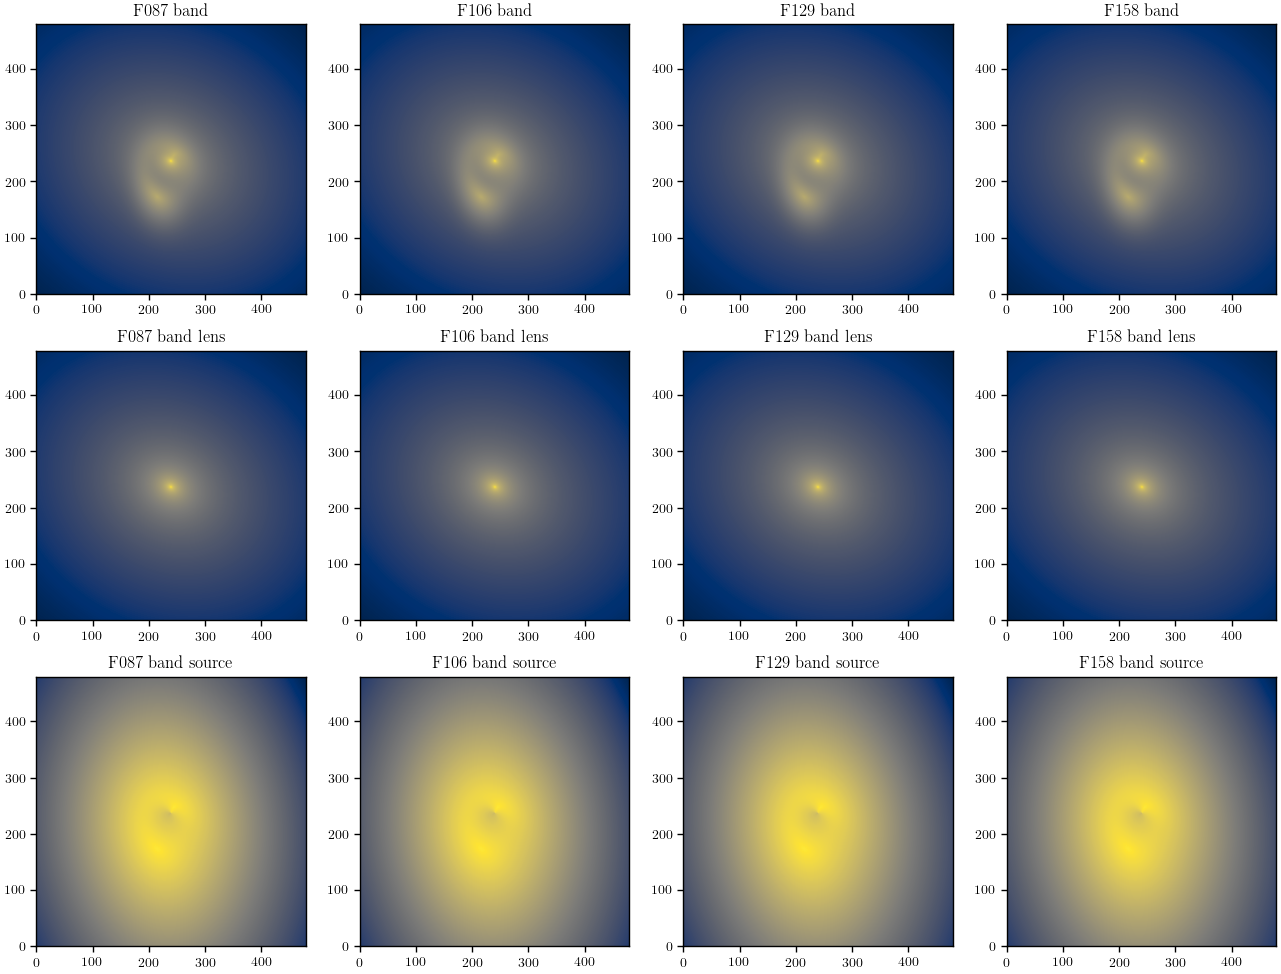

In [26]:
f, ax = plt.subplots(3, 4, figsize=(16, 12))
for i, band in enumerate(bands):
    ax[0, i].imshow(np.log10(arrays[i]), origin='lower', cmap='cividis')
    ax[0, i].set_title(f'{band} band')
    ax[1, i].imshow(np.log10(lens_surface_brightness[i]), origin='lower', cmap='cividis')
    ax[1, i].set_title(f'{band} band lens')
    ax[2, i].imshow(np.log10(source_surface_brightness[i]), origin='lower', cmap='cividis')
    ax[2, i].set_title(f'{band} band source')
plt.show()

fits file hierarchy
* primary_hdu: color image
* image 1: everything in F087 ...
* image 5: source in F087 ...
* image 9: lens in F087 ...

In [41]:
fits_path = os.path.join(repo_dir, f'lens_{str(uid).zfill(8)}.fits')

In [42]:
pipeline_params = util.hydra_to_dict(config.pipeline)

In [50]:
primary_header = fits.Header()

# mejiro metadata
import mejiro

primary_header['VERSION'] = mejiro.__version__

import getpass
import platform

primary_header['AUTHOR'] = (f'{getpass.getuser()}@{platform.node()}', 'username@host for calculation')

# TODO detector and detector position
# header['DETECTOR']
# header['DET_X']
# header['DET_Y']
# TODO RA and dec

primary_header['R_BAND'] = pipeline_params['rgb_bands'][0]
primary_header['G_BAND'] = pipeline_params['rgb_bands'][1]
primary_header['B_BAND'] = pipeline_params['rgb_bands'][2]

primary_hdu = fits.PrimaryHDU(color_image, primary_header)
hdul = fits.HDUList([primary_hdu])

for band, array in zip(bands, arrays):
    header = fits.Header()
    header['INSTRUME'] = ('WFI', 'Instrument')
    header['FILTER'] = (band, 'Filter')
    header['EXPOSURE'] = (pipeline_params['exposure_time'], 'Exposure time [seconds]')
    header['OVERSAMP'] = (pipeline_params['grid_oversample'], 'Oversampling used in calculation')
    header['PIXELSCL'] = (0.11, 'Pixel scale [arcsec/pixel]')
    header['FOV'] = (0.11 * pipeline_params['final_pixel_side'], 'Field of view [arcsec]')

    image_hdu = fits.ImageHDU(array, header, name=band)
    hdul.append(image_hdu)

for band, array in zip(bands, source_surface_brightness):
    header = fits.Header()
    header['INSTRUME'] = ('WFI', 'Instrument')
    header['FILTER'] = (band, 'Filter')
    header['EXPOSURE'] = (pipeline_params['exposure_time'], 'Exposure time [seconds]')
    header['OVERSAMP'] = (pipeline_params['grid_oversample'], 'Oversampling used in calculation')
    header['PIXELSCL'] = (0.11, 'Pixel scale [arcsec/pixel]')
    header['FOV'] = (0.11 * pipeline_params['final_pixel_side'], 'Field of view [arcsec]')

    image_hdu = fits.ImageHDU(array, header, name=f'{band} SOURCE')
    hdul.append(image_hdu)

for band, array in zip(bands, lens_surface_brightness):
    header = fits.Header()
    header['INSTRUME'] = ('WFI', 'Instrument')
    header['FILTER'] = (band, 'Filter')
    header['EXPOSURE'] = (pipeline_params['exposure_time'], 'Exposure time [seconds]')
    header['OVERSAMP'] = (pipeline_params['grid_oversample'], 'Oversampling used in calculation')
    header['PIXELSCL'] = (0.11, 'Pixel scale [arcsec/pixel]')
    header['FOV'] = (0.11 * pipeline_params['final_pixel_side'], 'Field of view [arcsec]')

    image_hdu = fits.ImageHDU(array, header, name=f'{band} LENS')
    hdul.append(image_hdu)

hdul.writeto(fits_path, overwrite=True)

In [51]:
fits.info(fits_path)

Filename: /home/btwedig/mejiro/lens_00000002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (3, 90, 90)   uint8   
  1  F087          1 ImageHDU        14   (480, 480)   float64   
  2  F106          1 ImageHDU        14   (480, 480)   float64   
  3  F129          1 ImageHDU        14   (480, 480)   float64   
  4  F158          1 ImageHDU        14   (480, 480)   float64   
  5  F087 SOURCE    1 ImageHDU        14   (480, 480)   float64   
  6  F106 SOURCE    1 ImageHDU        14   (480, 480)   float64   
  7  F129 SOURCE    1 ImageHDU        14   (480, 480)   float64   
  8  F158 SOURCE    1 ImageHDU        14   (480, 480)   float64   
  9  F087 LENS     1 ImageHDU        14   (480, 480)   float64   
 10  F106 LENS     1 ImageHDU        14   (480, 480)   float64   
 11  F129 LENS     1 ImageHDU        14   (480, 480)   float64   
 12  F158 LENS     1 ImageHDU        14   (480, 480)   float64   
